# Maximum Accuracy Model Training Strategy
## Advanced Stacked Ensemble for Drug Category Classification

**Objective:** Achieve maximum accuracy using state-of-the-art ensemble methods

**Strategy:**
- Layer 1: Multiple diverse base models (XGBoost, LightGBM, CatBoost, RF, ExtraTrees, NN)
- Layer 2: Stacked meta-models
- Bayesian hyperparameter optimization
- 10-fold stratified cross-validation

In [ ]:
!git clone https://github.com/NuwanHapuarachchi/icds-2025-mini-hackathon.git

Cloning into 'icds-2025-mini-hackathon'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 114 (delta 18), reused 103 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (114/114), 9.07 MiB | 17.55 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [ ]:
%cd icds-2025-mini-hackathon
!ls

#install catboost
!pip install catboost
# !pip install lightgbm
# !pip install xgboost
# optuna
!pip install optuna


/content/icds-2025-mini-hackathon
colab.ipynb			  reports
data				  scripts
documentation			  Steps.md
MaxAccuracy_Model_Training.ipynb  TASK_COMPLETION_REPORT.md
Notebook.ipynb			  VERIFICATION_REPORT.md
PRE_MODELING_SUMMARY.md		  verification_results.json
README.md			  visualizations


In [ ]:
#check cuda pytorch
import torch
print(torch.cuda.is_available())
#check xgboost cuda


!nvidia-smi

True
Sun Nov 16 09:12:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P8             14W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+

## 1. Setup and Imports

In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn preprocessing and metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Base Models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Boosting models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Stacking
from sklearn.ensemble import StackingClassifier, VotingClassifier

# Hyperparameter optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
try:
    import optuna
    OPTUNA_AVAILABLE = True
except:
    OPTUNA_AVAILABLE = False
    print("Optuna not available. Using GridSearchCV/RandomizedSearchCV only.")

# Utilities
import joblib
from datetime import datetime
import os

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")
print(f"Optuna available: {OPTUNA_AVAILABLE}")

All libraries imported successfully!
Optuna available: True


## 2. Load Engineered Data

In [ ]:
# Load engineered datasets
train_df = pd.read_csv('data/data_minihackathon_train_engineered.csv')
test_df = pd.read_csv('data/data_minihackathon_test_engineered.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nTarget distribution:")
print(train_df['drug_category'].value_counts())

# Separate features and target
X = train_df.drop(['drug_category', 'id'], axis=1, errors='ignore')
y = train_df['drug_category']
X_test = test_df.drop(['id'], axis=1, errors='ignore')
test_ids = test_df['id'] if 'id' in test_df.columns else np.arange(len(test_df))

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\nFeatures shape: {X.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"\nClass encoding: {dict(enumerate(le.classes_))}")

Train shape: (1500, 46)
Test shape: (377, 45)

Target distribution:
drug_category
Hallucinogens    691
Stimulants       567
Depressants      242
Name: count, dtype: int64

Features shape: (1500, 45)
Test features shape: (377, 45)

Class encoding: {0: 'Depressants', 1: 'Hallucinogens', 2: 'Stimulants'}


## 3. Cross-Validation Setup

In [ ]:
# Stratified K-Fold for cross-validation
N_FOLDS = 10
RANDOM_STATE = 42

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Storage for model results
model_results = {}
oof_predictions = {}  # Out-of-fold predictions for stacking

print(f"Using {N_FOLDS}-fold stratified cross-validation")
print(f"Random state: {RANDOM_STATE}")

Using 10-fold stratified cross-validation
Random state: 42


## 4. Layer 1: Base Models
### 4.1 XGBoost with Bayesian Optimization

In [ ]:
%%time

print("\n" + "="*80)
print("Training XGBoost with Hyperparameter Tuning")
print("="*80)

if OPTUNA_AVAILABLE:
    # Bayesian optimization with Optuna
    def objective_xgb(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 800),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.15, log=True),
            'min_child_weight': trial.suggest_int('min_child_weight', 2, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 0.95),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
            'gamma': trial.suggest_float('gamma', 0, 0.5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 2),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
            'random_state': RANDOM_STATE,
            'tree_method': 'hist', # Changed from 'gpu_hist'
            'device': 'cuda',
            'eval_metric': 'mlogloss'
        }

        model = xgb.XGBClassifier(**params)
        scores = cross_val_score(model, X, y_encoded, cv=skf, scoring='accuracy', n_jobs=-1)
        return scores.mean()

    study_xgb = optuna.create_study(direction='maximize', study_name='xgboost')
    study_xgb.optimize(objective_xgb, n_trials=20, show_progress_bar=True)

    print(f"\nBest XGBoost accuracy: {study_xgb.best_value:.4f}")
    print(f"Best parameters: {study_xgb.best_params}")

    # Train final model with best parameters
    xgb_model = xgb.XGBClassifier(**study_xgb.best_params)

else:
    # Randomized search as fallback
    param_dist = {
        'n_estimators': [100, 300, 500, 700, 1000],
        'max_depth': [3, 5, 7, 9, 11],
        'learning_rate': [0.001, 0.01, 0.05, 0.1],
        'min_child_weight': [1, 3, 5, 7],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2, 0.3],
        'reg_alpha': [0, 0.01, 0.1, 1],
        'reg_lambda': [0, 0.01, 0.1, 1]
    }

    xgb_base = xgb.XGBClassifier(random_state=RANDOM_STATE, tree_method='hist', device='cuda', eval_metric='mlogloss') # Changed from 'gpu_hist'
    random_search = RandomizedSearchCV(xgb_base, param_dist, n_iter=5, cv=5,
                                      scoring='accuracy', n_jobs=-1, random_state=RANDOM_STATE)
    random_search.fit(X, y_encoded)

    print(f"\nBest XGBoost accuracy: {random_search.best_score_:.4f}")
    print(f"Best parameters: {random_search.best_params_}")

    xgb_model = random_search.best_estimator_

# Evaluate with cross-validation
cv_results = cross_validate(xgb_model, X, y_encoded, cv=skf,
                           scoring=['accuracy', 'f1_macro'], return_train_score=True)

model_results['XGBoost'] = {
    'cv_accuracy': cv_results['test_accuracy'].mean(),
    'cv_std': cv_results['test_accuracy'].std(),
    'f1_macro': cv_results['test_f1_macro'].mean(),
    'model': xgb_model
}

print(f"\nXGBoost CV Accuracy: {model_results['XGBoost']['cv_accuracy']:.4f} \u00b1 {model_results['XGBoost']['cv_std']:.4f}")
print(f"XGBoost F1-Macro: {model_results['XGBoost']['f1_macro']:.4f}")

[I 2025-11-16 10:58:54,331] A new study created in memory with name: xgboost



Training XGBoost with Hyperparameter Tuning


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-11-16 10:59:19,743] Trial 0 finished with value: 0.7106666666666668 and parameters: {'n_estimators': 339, 'max_depth': 5, 'learning_rate': 0.012732039332567717, 'min_child_weight': 2, 'subsample': 0.8160671593666856, 'colsample_bytree': 0.8646496910450345, 'gamma': 0.44256700822207623, 'reg_alpha': 0.4753324187764121, 'reg_lambda': 1.6545742578027602}. Best is trial 0 with value: 0.7106666666666668.
[I 2025-11-16 10:59:57,243] Trial 1 finished with value: 0.7093333333333333 and parameters: {'n_estimators': 362, 'max_depth': 10, 'learning_rate': 0.014098965331934618, 'min_child_weight': 6, 'subsample': 0.6664353587349927, 'colsample_bytree': 0.8062121150854167, 'gamma': 0.3483466923437016, 'reg_alpha': 0.24814371466489704, 'reg_lambda': 1.9516405729383028}. Best is trial 0 with value: 0.7106666666666668.
[I 2025-11-16 11:00:16,165] Trial 2 finished with value: 0.716 and parameters: {'n_estimators': 407, 'max_depth': 3, 'learning_rate': 0.01624730866675407, 'min_child_weight': 6,

### 4.2 LightGBM with Hyperparameter Tuning

In [ ]:
%%time

print("\n" + "="*80)
print("Training LightGBM with Hyperparameter Tuning")
print("="*80)

if OPTUNA_AVAILABLE:
    def objective_lgb(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 800),
            'num_leaves': trial.suggest_int('num_leaves', 15, 100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 15, 80),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 0.95),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.95),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'lambda_l1': trial.suggest_float('lambda_l1', 0, 5),
            'lambda_l2': trial.suggest_float('lambda_l2', 0, 5),
            'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 0.5),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'random_state': RANDOM_STATE,
            'device': 'gpu',
            'verbose': -1,
            'force_col_wise': True
        }

        model = lgb.LGBMClassifier(**params)
        scores = cross_val_score(model, X, y_encoded, cv=skf, scoring='accuracy', n_jobs=-1)
        return scores.mean()

    study_lgb = optuna.create_study(direction='maximize', study_name='lightgbm')
    study_lgb.optimize(objective_lgb, n_trials=25, show_progress_bar=True)

    print(f"\nBest LightGBM accuracy: {study_lgb.best_value:.4f}")
    print(f"Best parameters: {study_lgb.best_params}")

    lgb_model = lgb.LGBMClassifier(**study_lgb.best_params)

else:
    param_dist = {
        'n_estimators': [100, 300, 500, 700],
        'num_leaves': [15, 31, 63, 100],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_data_in_leaf': [15, 30, 50, 80],
        'feature_fraction': [0.6, 0.7, 0.8, 0.9],
        'bagging_fraction': [0.6, 0.7, 0.8, 0.9],
        'lambda_l1': [0, 0.1, 1, 5],
        'lambda_l2': [0, 0.1, 1, 5],
        'max_depth': [3, 5, 7, 10]
    }

    lgb_base = lgb.LGBMClassifier(random_state=RANDOM_STATE, device='gpu', verbose=-1, force_col_wise=True)
    random_search = RandomizedSearchCV(lgb_base, param_dist, n_iter=5, cv=5,
                                      scoring='accuracy', n_jobs=-1, random_state=RANDOM_STATE)
    random_search.fit(X, y_encoded)

    print(f"\nBest LightGBM accuracy: {random_search.best_score_:.4f}")
    print(f"Best parameters: {random_search.best_params_}")

    lgb_model = random_search.best_estimator_

cv_results = cross_validate(lgb_model, X, y_encoded, cv=skf,
                           scoring=['accuracy', 'f1_macro'], return_train_score=True)

model_results['LightGBM'] = {
    'cv_accuracy': cv_results['test_accuracy'].mean(),
    'cv_std': cv_results['test_accuracy'].std(),
    'f1_macro': cv_results['test_f1_macro'].mean(),
    'model': lgb_model
}

print(f"\nLightGBM CV Accuracy: {model_results['LightGBM']['cv_accuracy']:.4f} ± {model_results['LightGBM']['cv_std']:.4f}")
print(f"LightGBM F1-Macro: {model_results['LightGBM']['f1_macro']:.4f}")

[I 2025-11-16 11:07:06,786] A new study created in memory with name: lightgbm



Training LightGBM with Hyperparameter Tuning


  0%|          | 0/25 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

### 4.3 CatBoost with Hyperparameter Tuning

In [ ]:
%%time

print("\n" + "="*80)
print("Training CatBoost with Hyperparameter Tuning")
print("="*80)

if OPTUNA_AVAILABLE:
    def objective_cat(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 300, 2000),
            'depth': trial.suggest_int('depth', 4, 9),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
            'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 10),
            'border_count': trial.suggest_int('border_count', 32, 200),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 50),
            'random_state': RANDOM_STATE,
            'task_type': 'GPU',
            'verbose': 0
        }

        model = CatBoostClassifier(**params)
        scores = cross_val_score(model, X, y_encoded, cv=skf, scoring='accuracy', n_jobs=-1)
        return scores.mean()

    study_cat = optuna.create_study(direction='maximize', study_name='catboost')
    study_cat.optimize(objective_cat, n_trials=15, show_progress_bar=True)  # Fewer trials due to longer training

    print(f"\nBest CatBoost accuracy: {study_cat.best_value:.4f}")
    print(f"Best parameters: {study_cat.best_params}")

    cat_model = CatBoostClassifier(**study_cat.best_params)

else:
    param_dist = {
        'iterations': [500, 1000, 2000, 3000],
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.001, 0.01, 0.05, 0.1],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'border_count': [32, 64, 128, 254]
    }

    cat_base = CatBoostClassifier(random_state=RANDOM_STATE, task_type='GPU', verbose=0)
    random_search = RandomizedSearchCV(cat_base, param_dist, n_iter=5, cv=5,
                                      scoring='accuracy', n_jobs=-1, random_state=RANDOM_STATE)
    random_search.fit(X, y_encoded)

    print(f"\nBest CatBoost accuracy: {random_search.best_score_:.4f}")
    print(f"Best parameters: {random_search.best_params_}")

    cat_model = random_search.best_estimator_

cv_results = cross_validate(cat_model, X, y_encoded, cv=skf,
                           scoring=['accuracy', 'f1_macro'], return_train_score=True)

model_results['CatBoost'] = {
    'cv_accuracy': cv_results['test_accuracy'].mean(),
    'cv_std': cv_results['test_accuracy'].std(),
    'f1_macro': cv_results['test_f1_macro'].mean(),
    'model': cat_model
}

print(f"\nCatBoost CV Accuracy: {model_results['CatBoost']['cv_accuracy']:.4f} ± {model_results['CatBoost']['cv_std']:.4f}")
print(f"CatBoost F1-Macro: {model_results['CatBoost']['f1_macro']:.4f}")

[I 2025-11-16 11:48:36,022] A new study created in memory with name: catboost



Training CatBoost with Hyperparameter Tuning


  0%|          | 0/15 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1101:	learn: 0.5797631	total: 5.88s	remaining: 2.25s
1102:	learn: 0.5796725	total: 5.88s	remaining: 2.24s
1103:	learn: 0.5795273	total: 5.88s	remaining: 2.24s
1104:	learn: 0.5794089	total: 5.89s	remaining: 2.23s
1105:	learn: 0.5792457	total: 5.89s	remaining: 2.23s
1106:	learn: 0.5791238	total: 5.9s	remaining: 2.22s
1107:	learn: 0.5790118	total: 5.9s	remaining: 2.22s
1108:	learn: 0.5788446	total: 5.91s	remaining: 2.21s
1109:	learn: 0.5788084	total: 5.91s	remaining: 2.21s
1110:	learn: 0.5786296	total: 5.92s	remaining: 2.2s
1111:	learn: 0.5784276	total: 5.92s	remaining: 2.19s
1112:	learn: 0.5782837	total: 5.93s	remaining: 2.19s
1113:	learn: 0.5781544	total: 5.93s	remaining: 2.18s
1114:	learn: 0.5781231	total: 5.94s	remaining: 2.18s
1115:	learn: 0.5780510	total: 5.94s	remaining: 2.17s
1116:	learn: 0.5779541	total: 5.95s	remaining: 2.17s
1117:	learn: 0.5778797	total: 5.96s	remaining: 2.16s
1118:	learn: 0.5777911	total: 5.96s	remaining: 2.16

### 4.4 Random Forest (Deep)

In [ ]:
%%time

print("\n" + "="*80)
print("Training Random Forest with Hyperparameter Tuning")
print("="*80)

param_grid = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_base = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
random_search = RandomizedSearchCV(rf_base, param_grid, n_iter=5, cv=5,
                                  scoring='accuracy', n_jobs=-1, random_state=RANDOM_STATE)
random_search.fit(X, y_encoded)

print(f"\nBest Random Forest accuracy: {random_search.best_score_:.4f}")
print(f"Best parameters: {random_search.best_params_}")

rf_model = random_search.best_estimator_

cv_results = cross_validate(rf_model, X, y_encoded, cv=skf,
                           scoring=['accuracy', 'f1_macro'], return_train_score=True)

model_results['RandomForest'] = {
    'cv_accuracy': cv_results['test_accuracy'].mean(),
    'cv_std': cv_results['test_accuracy'].std(),
    'f1_macro': cv_results['test_f1_macro'].mean(),
    'model': rf_model
}

print(f"\nRandom Forest CV Accuracy: {model_results['RandomForest']['cv_accuracy']:.4f} ± {model_results['RandomForest']['cv_std']:.4f}")
print(f"Random Forest F1-Macro: {model_results['RandomForest']['f1_macro']:.4f}")


Training Random Forest with Hyperparameter Tuning

Best Random Forest accuracy: 0.7053
Best parameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}

Random Forest CV Accuracy: 0.7093 ± 0.0341
Random Forest F1-Macro: 0.5167
CPU times: user 40.7 s, sys: 1.33 s, total: 42 s
Wall time: 1min 29s


### 4.5 Extra Trees Classifier

In [ ]:
%%time

print("\n" + "="*80)
print("Training Extra Trees with Hyperparameter Tuning")
print("="*80)

param_grid = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

et_base = ExtraTreesClassifier(random_state=RANDOM_STATE, n_jobs=-1)
random_search = RandomizedSearchCV(et_base, param_grid, n_iter=5, cv=5,
                                  scoring='accuracy', n_jobs=-1, random_state=RANDOM_STATE)
random_search.fit(X, y_encoded)

print(f"\nBest Extra Trees accuracy: {random_search.best_score_:.4f}")
print(f"Best parameters: {random_search.best_params_}")

et_model = random_search.best_estimator_

cv_results = cross_validate(et_model, X, y_encoded, cv=skf,
                           scoring=['accuracy', 'f1_macro'], return_train_score=True)

model_results['ExtraTrees'] = {
    'cv_accuracy': cv_results['test_accuracy'].mean(),
    'cv_std': cv_results['test_accuracy'].std(),
    'f1_macro': cv_results['test_f1_macro'].mean(),
    'model': et_model
}

print(f"\nExtra Trees CV Accuracy: {model_results['ExtraTrees']['cv_accuracy']:.4f} ± {model_results['ExtraTrees']['cv_std']:.4f}")
print(f"Extra Trees F1-Macro: {model_results['ExtraTrees']['f1_macro']:.4f}")


Training Extra Trees with Hyperparameter Tuning

Best Extra Trees accuracy: 0.7147
Best parameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None}

Extra Trees CV Accuracy: 0.7100 ± 0.0237
Extra Trees F1-Macro: 0.5136
CPU times: user 19 s, sys: 1.28 s, total: 20.3 s
Wall time: 45.4 s


### 4.6 Neural Network (Deep)

In [ ]:
%%time

print("\n" + "="*80)
print("Training Neural Network with Hyperparameter Tuning")
print("="*80)

param_grid = {
    'hidden_layer_sizes': [(256, 128, 64, 32), (512, 256, 128), (1024, 512, 256)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'batch_size': [32, 64, 128]
}

nn_base = MLPClassifier(max_iter=5, early_stopping=True, random_state=RANDOM_STATE)
random_search = RandomizedSearchCV(nn_base, param_grid, n_iter=5, cv=5,
                                  scoring='accuracy', n_jobs=-1, random_state=RANDOM_STATE)
random_search.fit(X, y_encoded)

print(f"\nBest Neural Network accuracy: {random_search.best_score_:.4f}")
print(f"Best parameters: {random_search.best_params_}")

nn_model = random_search.best_estimator_

cv_results = cross_validate(nn_model, X, y_encoded, cv=skf,
                           scoring=['accuracy', 'f1_macro'], return_train_score=True)

model_results['NeuralNetwork'] = {
    'cv_accuracy': cv_results['test_accuracy'].mean(),
    'cv_std': cv_results['test_accuracy'].std(),
    'f1_macro': cv_results['test_f1_macro'].mean(),
    'model': nn_model
}

print(f"\nNeural Network CV Accuracy: {model_results['NeuralNetwork']['cv_accuracy']:.4f} ± {model_results['NeuralNetwork']['cv_std']:.4f}")
print(f"Neural Network F1-Macro: {model_results['NeuralNetwork']['f1_macro']:.4f}")


Training Neural Network with Hyperparameter Tuning

Best Neural Network accuracy: 0.6513
Best parameters: {'learning_rate_init': 0.0001, 'hidden_layer_sizes': (512, 256, 128), 'batch_size': 32, 'alpha': 0.001}

Neural Network CV Accuracy: 0.6680 ± 0.0281
Neural Network F1-Macro: 0.4839
CPU times: user 23.5 s, sys: 72 ms, total: 23.5 s
Wall time: 25.4 s


## 5. Base Model Comparison


BASE MODEL PERFORMANCE COMPARISON
        Model CV Accuracy CV Std F1-Macro
     CatBoost      0.7200 0.0233   0.5260
 Stack_LogReg      0.7160 0.0250   0.5181
     LightGBM      0.7153 0.0327   0.5271
      XGBoost      0.7147 0.0275   0.5303
  Voting_Soft      0.7127 0.0296   0.5157
   ExtraTrees      0.7100 0.0237   0.5136
 RandomForest      0.7093 0.0341   0.5167
NeuralNetwork      0.6680 0.0281   0.4839


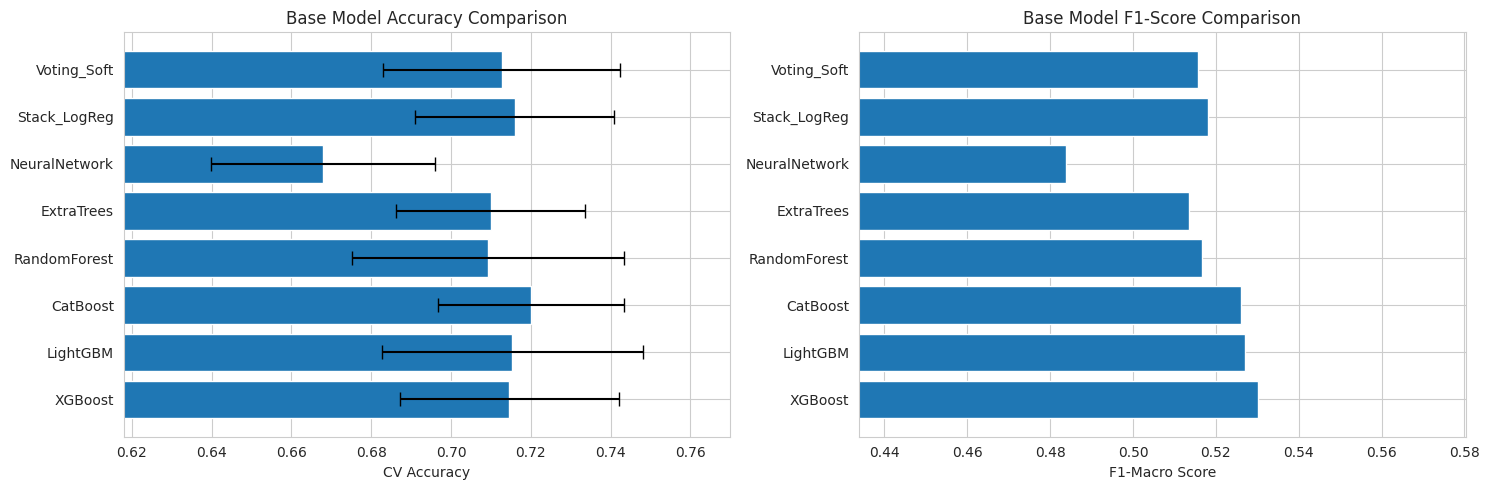


Visualization saved to: visualizations/base_model_comparison.png


In [ ]:
# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Model': name,
        'CV Accuracy': f"{results['cv_accuracy']:.4f}",
        'CV Std': f"{results['cv_std']:.4f}",
        'F1-Macro': f"{results['f1_macro']:.4f}"
    }
    for name, results in model_results.items()
]).sort_values('CV Accuracy', ascending=False)

print("\n" + "="*80)
print("BASE MODEL PERFORMANCE COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

# Create visualizations directory
os.makedirs('visualizations', exist_ok=True)

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy comparison
models = list(model_results.keys())
accuracies = [model_results[m]['cv_accuracy'] for m in models]
stds = [model_results[m]['cv_std'] for m in models]

axes[0].barh(models, accuracies, xerr=stds, capsize=5)
axes[0].set_xlabel('CV Accuracy')
axes[0].set_title('Base Model Accuracy Comparison')
axes[0].set_xlim([min(accuracies) - 0.05, max(accuracies) + 0.05])

# F1-Score comparison
f1_scores = [model_results[m]['f1_macro'] for m in models]
axes[1].barh(models, f1_scores)
axes[1].set_xlabel('F1-Macro Score')
axes[1].set_title('Base Model F1-Score Comparison')
axes[1].set_xlim([min(f1_scores) - 0.05, max(f1_scores) + 0.05])

plt.tight_layout()
plt.savefig('visualizations/base_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to: visualizations/base_model_comparison.png")

## 6. Layer 2: Stacking Ensemble

In [ ]:
%%time

print("\n" + "="*80)
print("Building Stacked Ensemble")
print("="*80)

# Select top 5 base models
sorted_models = sorted(model_results.items(), key=lambda x: x[1]['cv_accuracy'], reverse=True)
top_5_models = sorted_models[:5]

print("\nTop 5 base models for stacking:")
for i, (name, results) in enumerate(top_5_models, 1):
    print(f"{i}. {name}: {results['cv_accuracy']:.4f}")

# Create estimators list for stacking
estimators = [(name, results['model']) for name, results in top_5_models]

# Meta-model 1: Logistic Regression with class_weight='balanced'
print("\n" + "-"*80)
print("Stacking with Logistic Regression Meta-Model (BALANCED)")
print("-"*80)

stack_lr = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE),
    cv=5,
    n_jobs=-1
)

cv_results_lr = cross_validate(stack_lr, X, y_encoded, cv=skf,
                              scoring=['accuracy', 'f1_macro'], return_train_score=True)

model_results['Stack_LogReg'] = {
    'cv_accuracy': cv_results_lr['test_accuracy'].mean(),
    'cv_std': cv_results_lr['test_accuracy'].std(),
    'f1_macro': cv_results_lr['test_f1_macro'].mean(),
    'model': stack_lr
}

print(f"Stacking (LogReg) CV Accuracy: {model_results['Stack_LogReg']['cv_accuracy']:.4f} ± {model_results['Stack_LogReg']['cv_std']:.4f}")
print(f"Stacking (LogReg) F1-Macro: {model_results['Stack_LogReg']['f1_macro']:.4f}")

# Meta-model 2: XGBoost
print("\n" + "-"*80)
print("Stacking with XGBoost Meta-Model")
print("-"*80)

stack_xgb = StackingClassifier(
    estimators=estimators,
    final_estimator=xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3,
                                      tree_method='hist', device='cuda', random_state=RANDOM_STATE), # Changed 'gpu_hist' to 'hist'
    cv=5,
    n_jobs=-1
)

cv_results_xgb = cross_validate(stack_xgb, X, y_encoded, cv=skf,
                               scoring=['accuracy', 'f1_macro'], return_train_score=True)

model_results['Stack_XGB'] = {
    'cv_accuracy': cv_results_xgb['test_accuracy'].mean(),
    'cv_std': cv_results_xgb['test_accuracy'].std(),
    'f1_macro': cv_results_xgb['test_f1_macro'].mean(),
    'model': stack_xgb
}

print(f"Stacking (XGB) CV Accuracy: {model_results['Stack_XGB']['cv_accuracy']:.4f} ± {model_results['Stack_XGB']['cv_std']:.4f}")
print(f"Stacking (XGB) F1-Macro: {model_results['Stack_XGB']['f1_macro']:.4f}")


Building Stacked Ensemble

Top 5 base models for stacking:
1. CatBoost: 0.7200
2. Stack_LogReg: 0.7160
3. LightGBM: 0.7153
4. XGBoost: 0.7147
5. Voting_Soft: 0.7127

--------------------------------------------------------------------------------
Stacking with Logistic Regression Meta-Model
--------------------------------------------------------------------------------
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.7433374387257754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7433374387257754
[LightGBM] [Warning] lambda_l2 is set=3.819325564516405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.819325564516405
[LightGBM] [Warning] min_gain_to_split is set=0.16422011059809594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.16422011059809594
[LightGBM] [Warning] lambda_l1 is set=1.290183403003301, reg_a

## 7. Voting Ensemble

In [ ]:
%%time

print("\n" + "="*80)
print("Building Voting Ensemble")
print("="*80)

# Soft voting with top 5 models
voting_clf = VotingClassifier(
    estimators=estimators,
    voting='soft',
    n_jobs=-1
)

cv_results_vote = cross_validate(voting_clf, X, y_encoded, cv=skf,
                                scoring=['accuracy', 'f1_macro'], return_train_score=True)

model_results['Voting_Soft'] = {
    'cv_accuracy': cv_results_vote['test_accuracy'].mean(),
    'cv_std': cv_results_vote['test_accuracy'].std(),
    'f1_macro': cv_results_vote['test_f1_macro'].mean(),
    'model': voting_clf
}

print(f"Voting (Soft) CV Accuracy: {model_results['Voting_Soft']['cv_accuracy']:.4f} ± {model_results['Voting_Soft']['cv_std']:.4f}")
print(f"Voting (Soft) F1-Macro: {model_results['Voting_Soft']['f1_macro']:.4f}")

## 8. Final Model Selection and Comparison

In [ ]:
# Final comparison of all models
final_comparison_df = pd.DataFrame([
    {
        'Model': name,
        'CV Accuracy': results['cv_accuracy'],
        'CV Std': results['cv_std'],
        'F1-Macro': results['f1_macro']
    }
    for name, results in model_results.items()
]).sort_values('CV Accuracy', ascending=False)

print("\n" + "="*80)
print("FINAL MODEL PERFORMANCE COMPARISON (ALL MODELS)")
print("="*80)
print(final_comparison_df.to_string(index=False))

# Select best model
best_model_name = final_comparison_df.iloc[0]['Model']
best_model = model_results[best_model_name]['model']
best_accuracy = final_comparison_df.iloc[0]['CV Accuracy']

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"Best CV Accuracy: {best_accuracy:.4f}")
print(f"{'='*80}")

# Visualize final comparison
plt.figure(figsize=(12, 8))
plt.barh(final_comparison_df['Model'], final_comparison_df['CV Accuracy'],
         xerr=final_comparison_df['CV Std'], capsize=5)
plt.xlabel('CV Accuracy', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.title('Final Model Performance Comparison', fontsize=14, fontweight='bold')
plt.axvline(x=best_accuracy, color='r', linestyle='--', alpha=0.7, label=f'Best: {best_accuracy:.4f}')
plt.legend()
plt.tight_layout()
plt.savefig('visualizations/final_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to: visualizations/final_model_comparison.png")

## 9. Train Final Model on Full Dataset

In [ ]:
%%time

print("\n" + "="*80)
print(f"Training {best_model_name} on Full Dataset")
print("="*80)

# Train on full training data
best_model.fit(X, y_encoded)

# Training predictions
train_pred = best_model.predict(X)
train_accuracy = accuracy_score(y_encoded, train_pred)

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"\nClassification Report (Training):")
print(classification_report(y_encoded, train_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_encoded, train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'{best_model_name} - Confusion Matrix (Training)', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.savefig('visualizations/confusion_matrix_training.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConfusion matrix saved to: visualizations/confusion_matrix_training.png")

## 10. Generate Test Predictions

## 9.5 Verify Class Distribution in Predictions

In [ ]:
# CRITICAL: Check if model predicts all 3 classes
print("="*80)
print("CRITICAL CLASS DISTRIBUTION CHECK")
print("="*80)

# Check training predictions
train_pred_check = best_model.predict(X)
train_pred_classes = le.inverse_transform(train_pred_check)
train_dist = pd.Series(train_pred_classes).value_counts()

print("\nTraining Predictions Distribution:")
print(train_dist)
print(f"\nClasses predicted: {len(train_dist)} out of 3")

# Check test predictions (before final submission)
test_pred_check = best_model.predict(X_test)
test_pred_classes_check = le.inverse_transform(test_pred_check)
test_dist = pd.Series(test_pred_classes_check).value_counts()

print("\nTest Predictions Distribution:")
print(test_dist)
print(f"\nClasses predicted: {len(test_dist)} out of 3")

# Check prediction probabilities
test_pred_proba_check = best_model.predict_proba(X_test)
print(f"\nPrediction probability shape: {test_pred_proba_check.shape}")
print(f"Classes in model: {le.classes_}")

# Check if Depressants is being predicted
if 'Depressants' not in test_dist:
    print("\n🚨 WARNING: Depressants class is NOT being predicted!")
    print("This will severely hurt competition score!")
    
    # Find maximum probability for Depressants class
    depressants_idx = list(le.classes_).index('Depressants')
    max_depressant_prob = test_pred_proba_check[:, depressants_idx].max()
    mean_depressant_prob = test_pred_proba_check[:, depressants_idx].mean()
    
    print(f"\nDepressants class probabilities:")
    print(f"  Max probability: {max_depressant_prob:.4f}")
    print(f"  Mean probability: {mean_depressant_prob:.4f}")
    print(f"\nModel is not confident enough to predict Depressants class!")
else:
    print("\n✓ All 3 classes are being predicted")
    print(f"  Depressants: {test_dist.get('Depressants', 0)} predictions")

In [ ]:
%%time

print("\n" + "="*80)
print("Generating Test Predictions")
print("="*80)

# Make predictions on test set
test_pred_encoded = best_model.predict(X_test)
test_pred = le.inverse_transform(test_pred_encoded)

# Get prediction probabilities
test_pred_proba = best_model.predict_proba(X_test)

print(f"\nTest predictions generated: {len(test_pred)}")
print(f"\nPrediction distribution:")
print(pd.Series(test_pred).value_counts())

# Create submission file
submission = pd.DataFrame({
    'id': test_ids,
    'drug_category': test_pred
})

submission_filename = f"submission_{best_model_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
submission.to_csv(submission_filename, index=False)

print(f"\nSubmission file created: {submission_filename}")
print(f"\nFirst 10 predictions:")
print(submission.head(10))

## 11. Save Models

In [ ]:
# Create models directory
os.makedirs('models', exist_ok=True)

# Save best model
best_model_filename = f"models/best_model_{best_model_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pkl"
joblib.dump(best_model, best_model_filename)
print(f"Best model saved: {best_model_filename}")

# Save label encoder
le_filename = "models/label_encoder.pkl"
joblib.dump(le, le_filename)
print(f"Label encoder saved: {le_filename}")

# Save all model results
results_filename = "models/model_results.pkl"
joblib.dump(model_results, results_filename)
print(f"All model results saved: {results_filename}")

# Save comparison dataframe
final_comparison_df.to_csv('models/model_comparison.csv', index=False)
print("Model comparison saved: models/model_comparison.csv")

## 12. Summary and Recommendations

In [ ]:
print("\n" + "="*80)
print("TRAINING SUMMARY")
print("="*80)

print(f"\nTotal models trained: {len(model_results)}")
print(f"\nBest performing model: {best_model_name}")
print(f"Best CV Accuracy: {best_accuracy:.4f}")
print(f"Best F1-Macro: {final_comparison_df.iloc[0]['F1-Macro']:.4f}")

print(f"\n{'='*80}")
print("TOP 5 MODELS")
print("="*80)
print(final_comparison_df.head().to_string(index=False))

print(f"\n{'='*80}")
print("RECOMMENDATIONS")
print("="*80)
print("\n1. Use the best model for final submission")
print("2. Consider ensemble of top 3-5 models for potentially better results")
print("3. Monitor for overfitting - check train vs validation gap")
print("4. If time permits, run additional Bayesian optimization trials")
print("5. Consider feature engineering if accuracy needs improvement")

print(f"\n{'='*80}")
print("FILES GENERATED")
print("="*80)
print(f"1. Submission: {submission_filename}")
print(f"2. Best model: {best_model_filename}")
print(f"3. Label encoder: {le_filename}")
print(f"4. Model results: {results_filename}")
print("5. Visualizations: visualizations/")
print("6. Model comparison: models/model_comparison.csv")

print(f"\n{'='*80}")
print("TRAINING COMPLETE!")
print("="*80)